In [1]:
import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import os
from ProjectF import MLAData,classification, Object,storing
import random

In [2]:
TrainPlateDir = os.path.normpath("D:\Data\Plate_Name.txt")
with open(TrainPlateDir) as f:
    Spectra_Files = f.read().splitlines()


['spPlate-4176-55682.fits',
 'spPlate-4390-55948.fits',
 'spPlate-4205-55454.fits',
 'spPlate-4406-55858.fits',
 'spPlate-4235-55451.fits',
 'spPlate-4415-55831.fits',
 'spPlate-4833-55679.fits',
 'spPlate-5177-56245.fits',
 'spPlate-5699-55953.fits',
 'spPlate-4877-55707.fits',
 'spPlate-5208-56008.fits',
 'spPlate-5714-56660.fits',
 'spPlate-4901-55711.fits',
 'spPlate-5300-55982.fits',
 'spPlate-5775-56009.fits',
 'spPlate-4974-56038.fits',
 'spPlate-5364-56000.fits',
 'spPlate-5809-56353.fits',
 'spPlate-5000-55715.fits',
 'spPlate-5408-56038.fits',
 'spPlate-5889-56038.fits',
 'spPlate-5045-56181.fits',
 'spPlate-5482-56017.fits',
 'spPlate-5941-56193.fits',
 'spPlate-5113-55924.fits',
 'spPlate-5656-55940.fits',
 'spPlate-5981-56340.fits',
 'spPlate-6013-56074.fits',
 'spPlate-6124-56211.fits',
 'spPlate-6200-56217.fits',
 'spPlate-6060-56074.fits',
 'spPlate-6173-56238.fits',
 'spPlate-6265-56248.fits',
 'spPlate-6638-56370.fits',
 'spPlate-7130-56568.fits',
 'spPlate-6322-56190

In [3]:
PLATEIDs = []
BinInfos = []
Flux = []
MJDs = []
log_wavst=[]
ANDMASK=[]
INVAR=[]
TrainingDir = os.path.normpath("D:\Data")
TrainingFolder =  os.path.normpath("\Training")
slash =  os.path.normpath("\\")
for spectrum in Spectra_Files:
    plate_ = fits.open( TrainingDir +TrainingFolder+slash+ spectrum ,memmap=True)
    Bin_info_ = plate_[5].data
    Flux_ = plate_[0].data
    primhdu_ = plate_[0]
    ANDMASK.append( plate_[2].data)
    INVAR.append( plate_[1].data)
    PLATEIDs.append(primhdu_.header['PLATEID'])
    log_wavst.append(primhdu_.header['COEFF0'])
    MJDs.append(primhdu_.header['MJD'])
    BinInfos.append(Bin_info_)
    Flux.append(Flux_)
    

In [4]:
list = fits.open(TrainingDir+slash+'Superset_DR12Q.fits',memmap=True)#opening file

supers=list[1].data # storing  BINTABLE extension data

In [5]:
Full_Data = storing(PLATEIDs,supers)

Plate Storage Completed: 1.2195121951219512%
Plate Storage Completed: 2.4390243902439024%
Plate Storage Completed: 3.658536585365854%
Plate Storage Completed: 4.878048780487805%
Plate Storage Completed: 6.097560975609756%
Plate Storage Completed: 7.317073170731708%
Plate Storage Completed: 8.536585365853659%
Plate Storage Completed: 9.75609756097561%
Plate Storage Completed: 10.975609756097562%
Plate Storage Completed: 12.195121951219512%
Plate Storage Completed: 13.414634146341463%
Plate Storage Completed: 14.634146341463415%
Plate Storage Completed: 15.853658536585366%
Plate Storage Completed: 17.073170731707318%
Plate Storage Completed: 18.29268292682927%
Plate Storage Completed: 19.51219512195122%
Plate Storage Completed: 20.73170731707317%
Plate Storage Completed: 21.951219512195124%
Plate Storage Completed: 23.170731707317074%
Plate Storage Completed: 24.390243902439025%
Plate Storage Completed: 25.609756097560975%
Plate Storage Completed: 26.829268292682926%
Plate Storage Comple

In [6]:
len(BinInfos)

82

In [7]:
X,Y,Train_z, Train_mag,All_AND,All_Inv,wav_logs,All_Name= MLAData(Full_Data,BinInfos,Flux, log_wavst,ANDMASK,INVAR)

In [8]:
len(X)

82

In [9]:
TestPlateDir = os.path.normpath("D:\Data\TestPlate_Name.txt")
with open(TestPlateDir) as f:
    Spectra_TestFiles = f.read().splitlines()
Spectra_TestFiles

['spPlate-4791-55889.fits',
 'spPlate-6970-56444.fits',
 'spPlate-5852-56034.fits',
 'spPlate-5484-56039.fits',
 'spPlate-6290-56238.fits',
 'spPlate-6122-56246.fits',
 'spPlate-6424-56272.fits',
 'spPlate-6723-56428.fits',
 'spPlate-6880-56543.fits']

In [10]:
TrainingDir = os.path.normpath("D:\Data")
TestingFolder =  os.path.normpath("\Test")
PLATEIDs_test = []
log_wavs=[]
BinInfos_test = []
Flux_test = []
AT = []
IT = []
z=0
for spectrum_test in Spectra_TestFiles:
    plate_test = fits.open(TrainingDir +TestingFolder+slash+spectrum_test ,memmap=True)
    Bin_info_test = plate_test[5].data
    Flux_t = plate_test[0].data
    primhdu_test = plate_test[0]
    AT.append( plate_[2].data)
    IT.append( plate_[1].data)
    PLATEIDs_test.append(primhdu_test.header['PLATEID'])
    log_wavs.append(primhdu_test.header['COEFF0'])
    BinInfos_test.append(Bin_info_test)
    Flux_test.append(Flux_t)


In [11]:
Full_Data_test = storing(PLATEIDs_test,supers)

Plate Storage Completed: 11.11111111111111%
Plate Storage Completed: 22.22222222222222%
Plate Storage Completed: 33.333333333333336%
Plate Storage Completed: 44.44444444444444%
Plate Storage Completed: 55.55555555555556%
Plate Storage Completed: 66.66666666666667%
Plate Storage Completed: 77.77777777777777%
Plate Storage Completed: 88.88888888888889%
Plate Storage Completed: 100.0%


In [12]:
X_test,Y_test,All_redshifts,All_Mag,All_AND,All_Inv,wav_logs,All_Name= MLAData(Full_Data_test,BinInfos_test,Flux_test,log_wavs,AT,IT )

Solvers: ‘lbfgs’ is an optimizer in the family of quasi-Newton methods. ‘sgd’ refers to stochastic gradient descent. ‘adam’ refers to a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba

In [13]:
hiddenlayer_format = (13)
backprop_method = 'lbfgs'
lr=0.00001
act =  'tanh' #'logistic'
mlp = MLPClassifier(hidden_layer_sizes=hiddenlayer_format,max_iter=500, solver = backprop_method,learning_rate_init=lr,activation=act) ##Think About

In [14]:
X_Full=[]
Y_Full = []
n=0
total = 0
while n< len(X):
    currentbinX = X[n]
    currentbinY = Y[n]
    i=0
    total=total + len(currentbinY)
    while i < len(currentbinY):
        X_Full.append(currentbinX[i])
        Y_Full.append(currentbinY[i])
        i=i+1
    n=n+1
        


print(len(X_Full))
print(total)

mlp.fit(X_Full,Y_Full)

18653
18653


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=13, learning_rate='constant',
       learning_rate_init=1e-05, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [15]:
XT_Full=[]
YT_Full = []
n=0
while n< len(X_test):
    currentbinX = X_test[n]
    currentbinY = Y_test[n]
    i=0
    total=total + len(currentbinY)
    while i < len(currentbinY):
        XT_Full.append(currentbinX[i])
        YT_Full.append(currentbinY[i])
        i=i+1
    n=n+1

predictions = mlp.predict(np.array(XT_Full))

In [16]:
print(classification_report(YT_Full,predictions))

             precision    recall  f1-score   support

          0       0.90      0.90      0.90       816
          1       0.77      0.73      0.75       481
          2       0.00      0.00      0.00        66
          3       0.82      0.92      0.87       791

avg / total       0.82      0.84      0.83      2154



In [19]:
star,star_starloc,star_lowzloc,star_galloc,star_highzloc = classification(0,YT_Full,predictions) 
lowz,lowz_starloc,lowz_loc,lowz_galloc,lowz_highzloc = classification(1,YT_Full,predictions)
gal,gal_starloc,gal_lowzloc,gal_galloc,gal_highzloc = classification(2,YT_Full,predictions)
highz,highz_starloc,highz_lowzloc,highz_galloc,highz_highzloc = classification(3,YT_Full,predictions)

In [ ]:
File_Name = input("Please Enter File name: ")

In [ ]:
d = open(TrainingDir+slash+File_Name+".txt", 'w')

In [ ]:
t1=["Files used to train: ",np.str(Spectra_Files), "\n"]
sp= "\n"
t2 = ["Files used to test: ",np.str(Spectra_TestFiles), "\n"]
t3 = ["Number of training objects = ",np.str(len(Spectra_Files)), "\n"]
t4 = ["Number of testing objects = ",np.str(len(Spectra_TestFiles)), "\n"]
n1 = ["Structure of neural network: ", np.str(hiddenlayer_format),"\n"]
n2  = ["Backpropagation method used: ",np.str(backprop_method), "\n"]
n3  = ["Learning rate: ",np.str(lr), "\n"]
n4  = ["Activation Function: ",np.str(act), "\n"]
r1 = ["Results of Neural Network: ", "\n","\n"]
r2=["        ","       Star    Quasar  Galaxy  BAL ","\n",]
r3="Star           ",np.str(np.round(star[0]*100,2)),"%  ", np.str(np.round(star[1]*100,2)),"%  ",np.str(np.round(star[2]*100,2)),"%  ",np.str(np.round(star[3]*100,2)),"%","\n"
r4="Quasar z<2.1   ",np.str(np.round( lowz[0]*100,2)),"%  ", np.str(np.round( lowz[1]*100,2)),"%  ",np.str(np.round( lowz[2]*100,2)),"%  ",np.str(np.round( lowz[3]*100,2)),"%","\n"
r5="Galaxy         ",np.str(np.round( gal[0]*100,2)),"%  ", np.str(np.round( gal[1]*100,2)),"%  ",np.str(np.round( gal[2]*100,2)),"%  ",np.str(np.round( gal[3]*100,2)),"%","\n"
r6="Quasar z<2.1   ",np.str(np.round( highz[0]*100,2)),"%  ", np.str(np.round( highz[1]*100,2)),"%  ",np.str(np.round( highz[2]*100,2)),"%  ",np.str(np.round (highz[3]*100,2)),"%","\n"

In [ ]:
d.writelines(t1)
d.writelines(sp)
d.writelines(t2)
d.writelines(sp)
d.writelines(t3)
d.writelines(t4)
d.writelines(sp)
d.writelines(sp)
d.writelines(n1)
d.writelines(n2)
d.writelines(n3)
d.writelines(n4)
d.writelines(sp)
d.writelines(sp)
d.writelines(r1)
d.writelines(r2)
d.writelines(r3)
d.writelines(r4)
d.writelines(r5)
d.writelines(r6)


In [ ]:
list.close()

In [ ]:
d.close()

In [21]:
misclass_highz1=random.choice(highz_starloc)
#misclass_highz2=random.choice(highz_galloc)
misclass_star=random.choice(star_lowzloc)
misclass_gal= random.choice(gal_lowzloc)


NameError: name 'misclass_highz2' is not defined

From (http://www.sdss.org/dr12/spectro/spectro_basics/) : 'About the Spectra', we  know:


<h5><center>log($\lambda_{i+1}$) - log($\lambda_{i}$)=0.0001.</center></h5>

I will use this, and the first pixels central wavelength, to produce the wavelength array for this plate. This will be done by finding the plate wavelength ratio: 

<h3><center>$\frac{\lambda_{i+1}}{\lambda_{i}}= 10^{0.0001}$.</center></h3>


In [ ]:
w_full=[]
i=0
while i<len(wav_logs):
    w_full.append(wav_logs[i]) 
    i=i+1
len(w_full)

In [23]:
wav_ratio = 10**0.0001
append_count=0
cent_wav = 10**wav_logs[0]
Y_flux = XT_Full[misclass_highz1]
wavelengths = []
wavelengths.append(cent_wav)
current_wav = cent_wav
while append_count < len(Y_flux)-1:
    current_wav = current_wav*wav_ratio
    wavelengths.append(current_wav)
    append_count=append_count+1

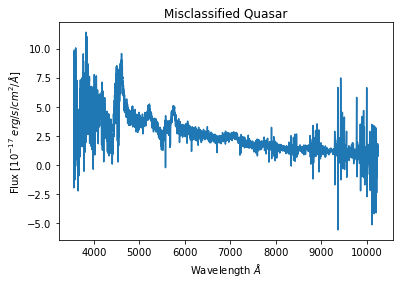

In [37]:
plt.plot(wavelengths,Y_flux)
plt.ylabel('Flux [$10^{-17}$ $erg/s/cm^2/$'r'$\AA$'']')
plt.xlabel('Wavelength' r' $\AA$')
plt.title('Misclassified Quasar')
plt.show()

In [26]:
)

KeyboardInterrupt: 

In [24]:
append_count=0
cent_wav2 = 10**wav_logs[0]
Y2_flux = XT_Full[misclass_star]
wavelengths2 = []
wavelengths2.append(cent_wav2)
current_wav2 = cent_wav2
while append_count < len(Y2_flux)-1:
    current_wav2 = current_wav2*wav_ratio
    wavelengths2.append(current_wav2)
    append_count=append_count+1

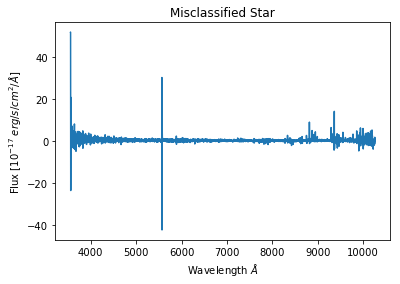

In [39]:
plt.plot(wavelengths2,Y2_flux)
plt.ylabel('Flux [$10^{-17}$ $erg/s/cm^2/$'r'$\AA$'']')
plt.xlabel('Wavelength' r' $\AA$')
plt.title('Misclassified Star')
plt.show()

In [25]:
#append_count=0
#cent_wav3 = 10**wav_logs[0]
Y3_flux = XT_Full[misclass_gal]
#wavelengths3 = []
#wavelengths3.append(cent_wav)
#current_wav3 = cent_wav3
#while append_count < len(Y3_flux)-1:
#    current_wav3 = current_wav3*wav_ratio
 #   wavelengths3.append(current_wav3)
  #  append_count=append_count+1

In [28]:
plt.plot(wavelengths2,Y3_flux)
plt.ylabel('Flux [$10^{-17}$ $erg/s/cm^2/$'r'$\AA$'']')
plt.xlabel('Wavelength' r' $\AA$')
plt.title('Misclassified Galaxy')
plt.savefig('galspec.png')

In [ ]:
append_count=0
cent_wav4 = 10**wav_logs[misclass_gal]
Y4_flux = X_test[misclass_gal]
wavelengths4 = []
wavelengths4.append(cent_wav4)
current_wav4 = cent_wav4
while append_count < len(Y4_flux)-1:
    current_wav4 = current_wav4*wav_ratio
    wavelengths4.append(current_wav4)
    append_count=append_count+1

In [ ]:
plt.plot(wavelengths4,Y4_flux)
plt.ylabel('Flux [$10^{-17}$ $erg/s/cm^2/$'r'$\AA$'']')
plt.xlabel('Wavelength' r' $\AA$')
plt.title('Misclassified Star as Quasar with z>2.1')
plt.show()

In [ ]:
Bin_no = input("Please Enter bin : ")

In [ ]:
X_bin,Y_bin,Train_z_bin, Train_mag_bin,wavst_bin = MLAData(Full_Data,BinInfos,Flux, log_wavst,Bin_no)

In [ ]:
X_test_bin,Y_test_bin,All_redshifts_bint,All_Ma_bintg,wav_logs_bin= MLAData(Full_Data_test,BinInfos_test,Flux_test,log_wavs)